## HMM.py

In [1]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 skeleton code
########################################

# You can use this (optional) skeleton code to complete the HMM
# implementation of set 5. Once each part is implemented, you can simply
# execute the related problem scripts (e.g. run 'python 2G.py') to quickly
# see the results from your code.
#
# Some pointers to get you started:
#
#     - Choose your notation carefully and consistently! Readable
#       notation will make all the difference in the time it takes you
#       to implement this class, as well as how difficult it is to debug.
#
#     - Read the documentation in this file! Make sure you know what
#       is expected from each function and what each variable is.
#
#     - Any reference to "the (i, j)^th" element of a matrix T means that
#       you should use T[i][j].
#
#     - Note that in our solution code, no NumPy was used. That is, there
#       are no fancy tricks here, just basic coding. If you understand HMMs
#       to a thorough extent, the rest of this implementation should come
#       naturally. However, if you'd like to use NumPy, feel free to.
#
#     - Take one step at a time! Move onto the next algorithm to implement
#       only if you're absolutely sure that all previous algorithms are
#       correct. We are providing you waypoints for this reason.
#
# To get started, just fill in code where indicated. Best of luck!

import random
import numpy as np

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize the length one prefixes.
        for state in range(self.L):
            seqs[1][state] = '{}'.format(state)
        
        # Update length 1 probabilities.
        for state in range(self.L):
            probs[1][state] = self.A_start[state] * self.O[state][x[0]]
          
        # For each row in probs, for each possible ending state, loop through possible prefixes from previous row
        # and multiply prob of that prefix by transition to current state. Record maximum probability
        # and corresponding sequence.
        
        for curr_length in range(2, M + 1): # Fill in each row for prefixes of different lengths
            
            for curr_state in range(self.L): # Possible ending states
                best_prob = 0
                best_seq = ''
                emission_prob = self.O[curr_state][x[curr_length - 1]]
                
                # Loop through possible prefixes
                for prefix_state in range(self.L):
                    transition_to_curr_state_prob = self.A[prefix_state][curr_state]
                    prefix_prob = probs[curr_length - 1][prefix_state]
                    prob_prefix_combo = prefix_prob * transition_to_curr_state_prob * emission_prob
                    
                    if best_prob < prob_prefix_combo:
                        best_prob = prob_prefix_combo
                        best_seq = seqs[curr_length - 1][prefix_state]
                
                # Update probs and seqs with best combo.
                probs[curr_length][curr_state] = best_prob
                seqs[curr_length][curr_state] = best_seq + str(curr_state)
        
        # Loop through possible sequences of length M and pick sequence with highest probability.
        best_seq_prob = 0
        max_seq = ''
        
        for ending_state in range(self.L):
            seq_prob = probs[M][ending_state]
            seq = seqs[M][ending_state]
            
            if seq_prob > best_seq_prob:
                best_seq_prob = seq_prob
                max_seq = seq
                
        return max_seq
        
    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0 for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize alphas.
        alphas[0] = self.A_start
        for state in range(self.L):
            alphas[1][state] = self.A_start[state] * self.O[state][x[0]]
        
        if normalize:
            total = sum(alphas[1])
            for i in range(len(alphas[1])):
                alphas[1][i] /= total
            
        # Fill in alphas for each length prefix.
        for curr_length in range(2, M + 1):
            
            # All possible curr_states.
            for curr_state in range(self.L):
                emission_prob = self.O[curr_state][x[curr_length - 1]]
                
                # All possible prefixes.
                for prefix_state in range(self.L):
                    transition_to_curr_state_prob = self.A[prefix_state][curr_state]
                    prefix_prob = alphas[curr_length - 1][prefix_state]
                    prob_prefix_combo = prefix_prob * transition_to_curr_state_prob * emission_prob
                    
                    alphas[curr_length][curr_state] += prob_prefix_combo
        
            # Normalize rows for each i (length of prefix), if specified.
            if normalize:
                tot = sum(alphas[curr_length])
                for j in range(len(alphas[curr_length])):
                    alphas[curr_length][j] /= tot
            
        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0 for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize end betas.
        for state in range(self.L):
            betas[M][state] = 1
            
        if normalize:
            tot = sum(betas[M])
            for i in range(len(betas[M])):
                betas[M][i] /= tot
        
        # Update betas backwards.
        for curr_length in range(M - 1, -1, -1):
            
            # All possible current states.
            for curr_state in range(self.L):
            
                # Loop through possible next states.
                for next_state in range(self.L):
                    emission_prob = self.O[next_state][x[curr_length]]
                    transition_to_next_state = self.A[curr_state][next_state]
                    next_state_prob = betas[curr_length + 1][next_state]
                    
                    prob_next_combo = emission_prob * transition_to_next_state * next_state_prob
                    betas[curr_length][curr_state] += prob_next_combo
        
            # Normalize if necessary.
            if normalize:
                total = sum(betas[curr_length])
                for j in range(len(betas[curr_length])):
                    betas[curr_length][j] /= total

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        
        # M is length of sequence
        # N is number of sequences
        N = len(Y)
        
        for a in range(len(self.A)):
            for b in range(len(self.A[0])):
                
                numerator = 0
                denominator = 0
                
                for j in range(0, N): # jth sequence
                    M_j = len(Y[j])
                    for i in range(0, M_j - 1): # ith term
                        numerator += (Y[j][i + 1] == b and Y[j][i] == a)
                        denominator += (Y[j][i] == a)
                        
                self.A[a][b] = numerator / denominator

        # Calculate each element of O using the M-step formulas.

        for z in range(len(self.O)):
            for w in range(len(self.O[0])):
                
                numerator = 0
                denominator = 0
                
                for j in range(0, N):
                    M_j = len(Y[j])
                    for i in range(0, M_j):
                        numerator += (X[j][i] == w and Y[j][i] == z)
                        denominator += (Y[j][i] == z)
                
                self.O[z][w] = numerator / denominator

        pass


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        for iteration in range(N_iters):
            A_num = [[0 for _ in range(self.L)] for _ in range(self.L)]
            A_den = [0 for _ in range(self.L)]
            O_num = [[0 for _ in range(self.D)] for _ in range(self.L)]
            O_den = [0 for _ in range(self.L)]
            
            for x in X:
                M = len(x)
                alphas = self.forward(x, normalize = True)
                betas = self.backward(x, normalize = True)
    
                for i in range(M - 1):
                    
                    marginals = [[alphas[i + 1][a] * self.A[a][b] * self.O[b][x[i + 1]] * betas[i + 2][b]
                                 for b in range(self.L)] for a in range(self.L)]
                    
                    tot = 0
                    for row in marginals:
                        tot += sum(row)
                    for row_idx in range(self.L):
                        for col_idx in range(self.L):
                            marginals[row_idx][col_idx] /= tot
                    
                    P_den = [alphas[i + 1][z] * betas[i + 1][z] for z in range(self.L)]
                    P_den = [item / sum(P_den) for item in P_den]
                    
                    for a in range(self.L):
                        for b in range(self.L):
                            A_num[a][b] += marginals[a][b]
                            
                        A_den[a] += P_den[a]
                        
                for i in range(M):
                    
                    P_den = [alphas[i + 1][z] * betas[i + 1][z] for z in range(self.L)]
                    P_den = [item / sum(P_den) for item in P_den]
                    
                    for z in range(self.L):
                        for w in range(self.D):
                            # 1[x^i = w] * P(y^i = z)
                            O_num[z][w] += (x[i] == w) * P_den[z]
                            # P(y^i = z)
                        O_den[z] += P_den[z]
                
            self.A = [[A_num[i][j] / A_den[i] for j in range(self.L)] for i in range(self.L)]
            self.O = [[O_num[i][j] / O_den[i] for j in range(self.D)] for i in range(self.L)]


    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''

        emission = []
        states = []
        
        curr_state = np.random.choice(list(range(self.L)), p = self.A_start)
        
        for i in range(M):
            curr_state = np.random.choice(list(range(self.L)), p = self.A[curr_state])
            states.append(curr_state)
            emission_i = np.random.choice(list(range(self.D)), p = self.O[curr_state])
            emission.append(emission_i)

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.

        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.

    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.

        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    random.seed(2020)
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    random.seed(155)
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM



In [2]:
import os
import numpy as np
from IPython.display import HTML

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
#     states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

import time

In [47]:
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

In [69]:
def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    nonzero_states = 0
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        if (len(obs_lst) != 0):
            obs_count.append(obs_lst)
            nonzero_states += 1

    # For each state, convert it into a wordcloud.
    for i in range(nonzero_states):
        obs_lst = obs_count[i]
        
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)
#         if (len(sentence_str) == 0):
#             print('skipped {}'.format(i))
#             continue
#         print(i)
        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

In [77]:
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation

def animate_emission(hmm, obs_map, M=8, height=30, width=30, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 400
    r = 30
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

## Visualization of the dataset

We will be using the Constitution as our dataset. First, we visualize the entirety of the Constitution as a wordcloud:

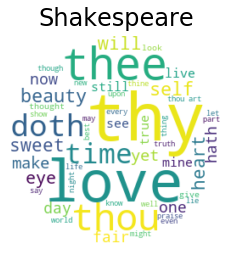

In [3]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

## Training an HMM

Now we train an HMM on our dataset. We use 10 hidden states and train over 100 iterations:

In [5]:
obs, obs_map = parse_observations(text)
t = time.time()
hmm8 = unsupervised_HMM(obs, 10, 100)
print(time.time() - t)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
187.32218527793884


In [10]:
t = time.time()
hmm30states = unsupervised_HMM(obs, 30, 100)
print(time.time() - t)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
1548.0905301570892


In [ ]:
reload()

## Part G: Visualization of the sparsities of A and O

We can visualize the sparsities of the A and O matrices by treating the matrix entries as intensity values and showing them as images. What patterns do you notice?

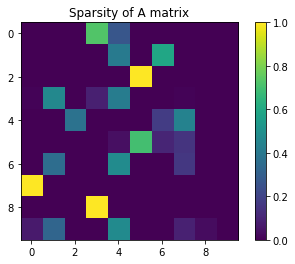

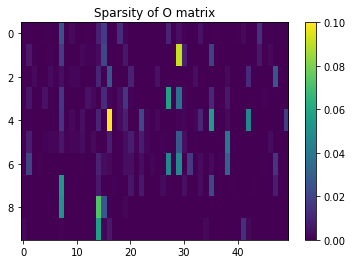

In [8]:
visualize_sparsities(hmm8, O_max_cols=50)

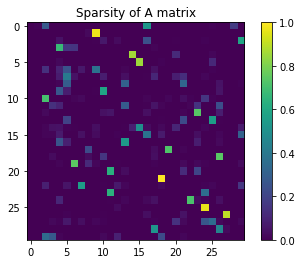

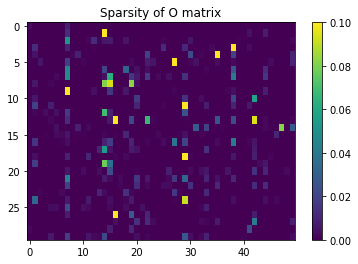

In [11]:
visualize_sparsities(hmm30states, O_max_cols=50)

## Generating a sample sentence

As you have already seen, an HMM can be used to generate sample sequences based on the given dataset. Run the cell below to show a sample sentence based on the Constitution.

In [11]:
print('Sample Sentence:\n====================')
print(sample_sentence(hmm8, obs_map, n_words=9))

Sample Sentence:
Immortal now is dead delights strength but be pleasure...


In [9]:
print('Sample Sentence:\n====================')
print(sample_sentence(hmm8, obs_map, n_words=50))

Sample Sentence:
Know with no leave tongues their course are his not love there all she lacking take foul against good i saw eye his thy conscience call budding praise an change poverty thou no that brought for others but have husband come bodys my pitywanting from with his words bestow he...


In [13]:
print('Sample Sentence 30 States:\n====================')
print(sample_sentence(hmm30states, obs_map, n_words=100))

Sample Sentence 30 States:
For fresh engrossed crowned strong praise which youth rather stelled dear in fits that thou record enrich fresh love mine flesh largess fearing after complain truetelling maladies for thy there of truth control with part objects be the the another shalt least this shalt as by ill wilt in a doubting of woe thou afar we not found greater soul is with a high plague or sail feeds cover which thinking or heavy fault i in on crave remove add barren weary right despise or black wandrest disgrace straight is could i do vex me created be wild dost fair...


In [23]:
print('Sample Sentence 30 States:\n====================')
print(sample_sentence(hmm30states, obs_map, n_words=100))

Sample Sentence 30 States:
Be mine glass alive were disgrace am cheeks will weed her blooms seemed thy own thought not and himself be for immortal love old compiled songs should grow it becoming untainted on things you hue both and me of ladies respect times would the mad at proves his than rehearse the palate one my fair other respect with just own others subject remain place this merit with rest story virtuous you before i could and strange fault asleep more taste doth thee days they lovekindling so almost say the visage may many seek my straying mens aught acquainted my then...


In [35]:
print('Sample Sentence 30 States:\n====================')
print(sample_sentence(hmm30states, obs_map, n_words=100))

Sample Sentence 30 States:
Heart cross done ten their wide to mine way depends to my self better mourning that not journey youth loves youth and my argument thy grace but to upon then as evident things keepst in my end not nor your rich and we make crowned respose please king force leaped of kiss which neverresting in strange water in thy infants that thy sin although so the physician in to this i see the tear dates might her is i truant a hideous pebbled to again well wires dare now their air to thy to with thy love honour the beard...


In [36]:
print('Sample Sentence 30 States:\n====================')
print(sample_sentence(hmm30states, obs_map, n_words=100))

Sample Sentence 30 States:
Her bright minds fears well ten be my and death still steepy true sorrow say is glory cannot i love but use be antiquity worthy i recured made form them besmeared away treasure from all would else deserved my poison shall with heavy though give done most they my untrue and my own mine pyramids for in stamp was cross nature were had say will shall be day some those thee that a swear thee for thy amiss hath writ all my discourse gives today most one live many time return place are my thought i honour bitter against gluttoning...


In [38]:
print('Sample Sentence 30 States:\n====================')
print(sample_sentence(hmm30states, obs_map, n_words=100))

Sample Sentence 30 States:
Coloured the life would side than let for all rain still good all breast of thee that lies remember better and to some heart when to the him that be you where summers art toward hath in or my own live my pyramids and winters define blots thee two the advised palate of stay by proof it doth thy shadow after fight proclaims slander my affairs changing return blunt thy heart soundless yet of leaves not to being long to blame farther to show forgot to a crime sweet and to upon remain beloved resemble time nor seldom self birth...


In [56]:
print('Sample Sentence 30 States:\n====================')
print(sample_sentence(hmm30states, obs_map, n_words=200))

Sample Sentence 30 States:
To the it breath rotten a this loves hast advantage swiftfooted of this he mayst argument string will and burn fears old the that hath thy some him makeless day groan doth mine at nothing hath light confessed delighted foiled stay your blood art worth not my sight knowst not the desired so times wise light to much better of thee and each of thy delight out beauty had slight fashion by basest having quest friend no tis mutual were i should yet a strained his self to thy love defeat days hideous faith words the broad eclipse of uphold equipage the being doth altring but this like preposterously such my mistress art in catch account keeps blushing as other dost in his saint did keep second back love when thy head self and to this strong neglect of bark those own case whose adieu old you whose dove health live for thy name own feelst pride true thence it of methinks true seem shalt all my eye is to is thee journey relief directly every one hymns already be clear 

## Part H: Using varying numbers of hidden states

Using different numbers of hidden states can lead to different behaviours in the HMMs. Below, we train several HMMs with 1, 2, 4, and 16 hidden states, respectively. What do you notice about their emissions? How do these emissions compare to the emission above?

In [7]:
hmm1 = unsupervised_HMM(obs, 1, 100)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm1, obs_map, n_words=25))

KeyboardInterrupt: 

In [7]:
hmm2 = unsupervised_HMM(obs, 2, 100)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm2, obs_map, n_words=25))


Sample Sentence:
Bill manner senate america seat formed one suppress vice support the application year being preside or seven shall for one and when prescribed of full...


In [8]:
hmm4 = unsupervised_HMM(obs, 4, 100)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm4, obs_map, n_words=25))


Sample Sentence:
To be such united those all regulations and the to and and any page the general respectively and inferior removed senate shall each president after...


In [9]:
hmm16 = unsupervised_HMM(obs, 16, 100)
print('\nSample Sentence:\n====================')
print(sample_sentence(hmm16, obs_map, n_words=25))


Sample Sentence:
Of will legislation and the that of imposts and demand of the legislature one when appointments and shall be and granted by law nothing all...


As the number of hidden states is increased, words that tend to follow each other in normal speech occur after each other. For instance "and granted by law" is a string that makes sense, whereas the first sentence seems more like a random jumble of words. In the case that there is only one hidden state, it can't transition to any other states, so the emissions that are produced only come from one state with the same probability distribution for each emission. This would be just like randomly sampling emission states with a given probability of choosing each emission. In general, we cannot increase the training data likelihood by allowing more hidden states. This is because the formula for computing the likelihood is $argmax \prod_{(x, y) \in S} P(x, y) = argmax \prod_{(x, y) \in S} P(End | y^M) \prod_{i=1}^M P(y^i | y^{i-1}) \prod_{i=1}^M P(x^i | y^i)$, and if we increase the number of states $y$, we will just be multiplying by more probabilities, which would decrease the likelihood.

## Part I: Visualizing the wordcloud of each state

Below, we visualize each state as a wordcloud by sampling a large emission from the state:

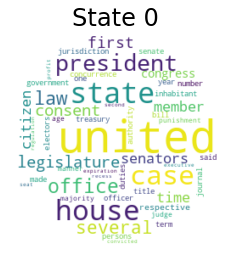

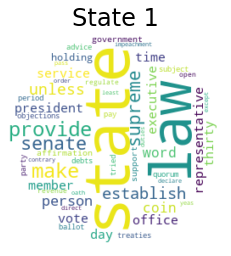

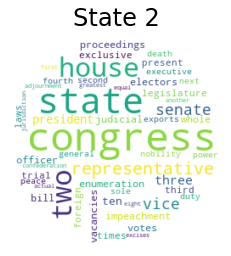

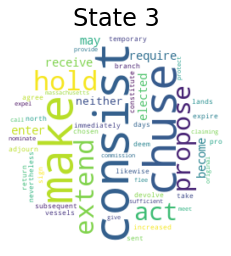

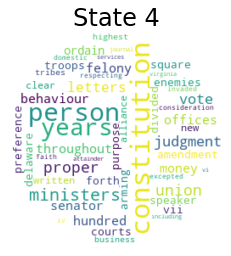

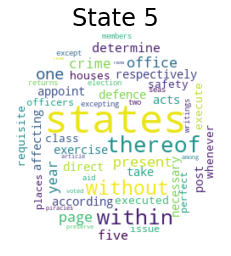

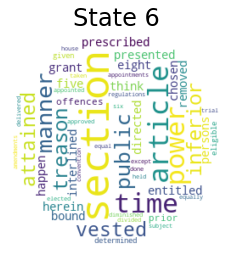

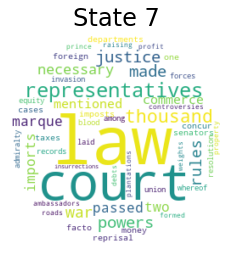

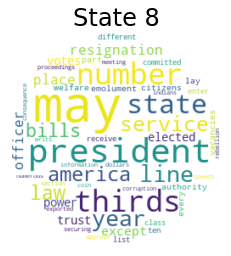

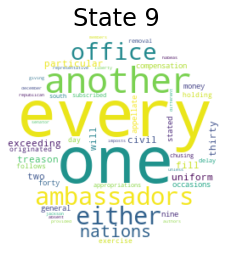

In [10]:
wordclouds = states_to_wordclouds(hmm8, obs_map)

skipped 0
1


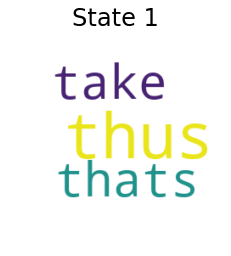

2


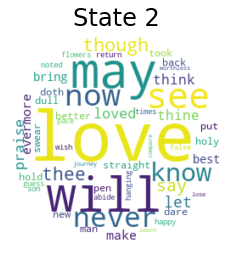

3


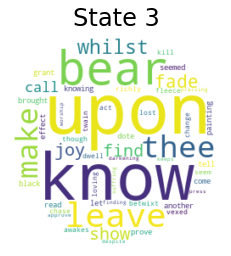

4


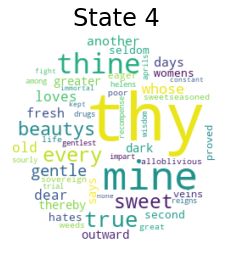

5


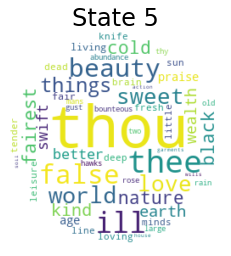

6


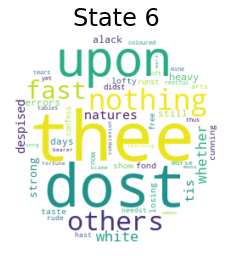

7


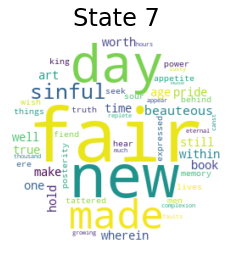

8


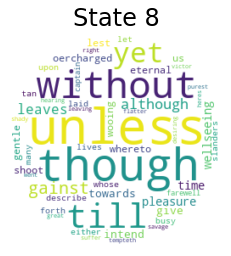

9


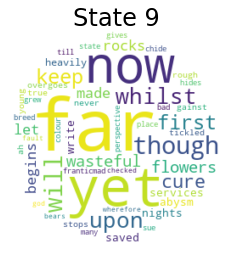

10


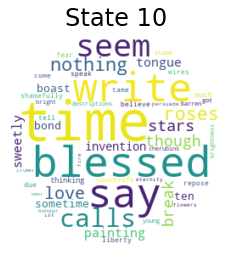

11


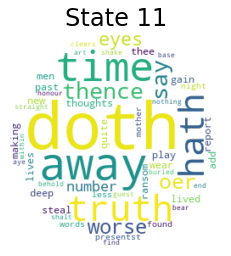

12


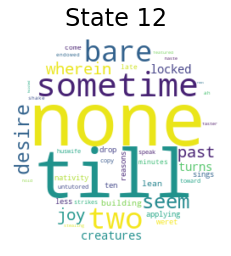

13


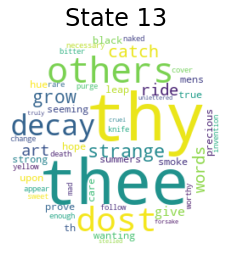

14


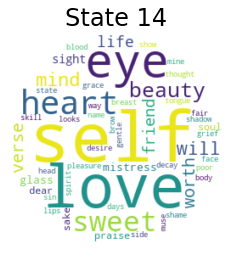

15


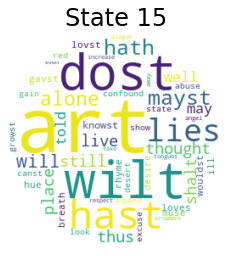

16


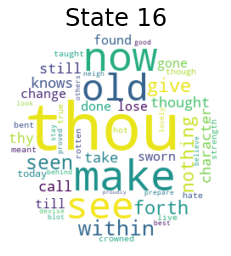

17


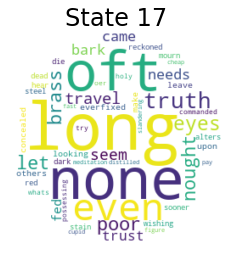

18


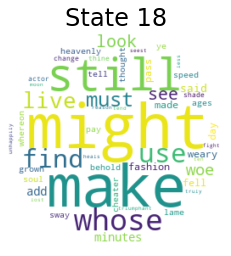

19


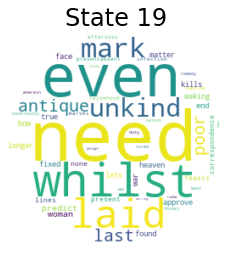

20


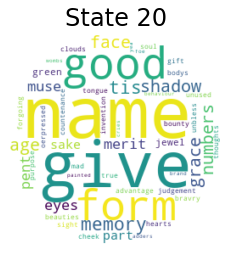

21


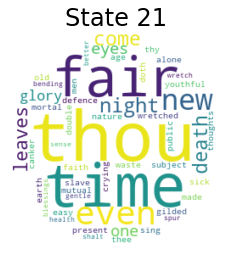

22


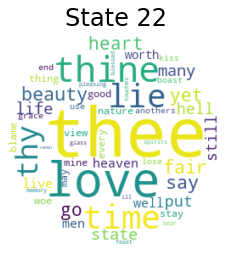

23


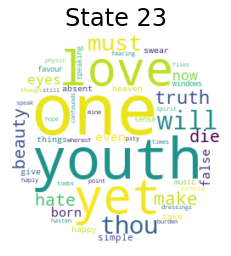

24


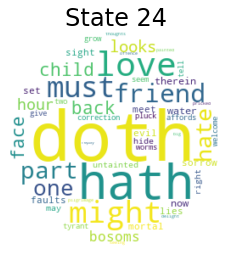

25


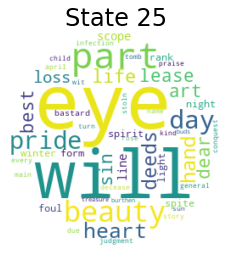

26


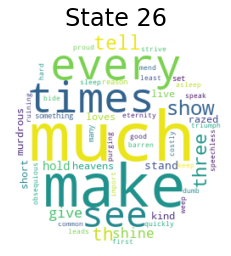

27


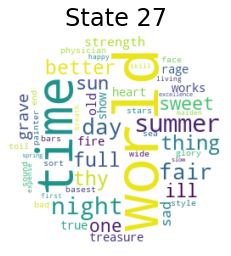

skipped 28
29


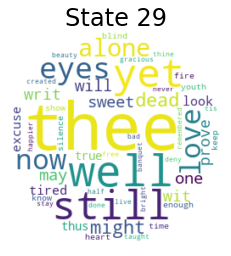

In [48]:
wordclouds = states_to_wordclouds(hmm30states, obs_map)

State 3 is semantically meaningful because it consists of action verbs, many of which have to do with law (as this was drawn from the constitution). Words such as "make, extend, consist, chuse, propose, hold, act, require" are prominent within this state. This is different from the other states, which generally have to do with government or law or justice but are a mixture of nouns and verbs.

## Visualizing the process of an HMM generating an emission

The visualization below shows how an HMM generates an emission. Each state is shown as a wordcloud on the plot, and transition probabilities between the states are shown as arrows. The darker an arrow, the higher the transition probability.

At every frame, a transition is taken and an observation is emitted from the new state. A red arrow indicates that the transition was just taken. If a transition stays at the same state, it is represented as an arrowhead on top of that state.

Use fullscreen for a better view of the process.


Animating...


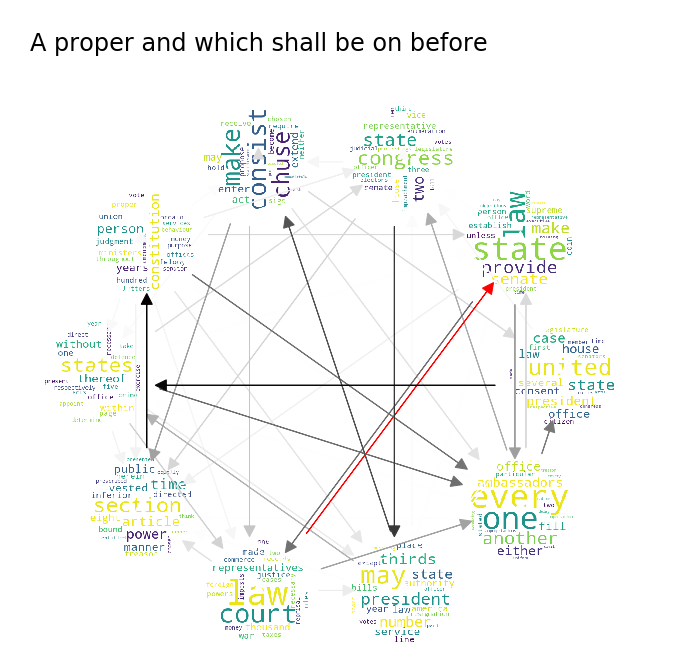

In [11]:
anim = animate_emission(hmm8, obs_map, M=8)
HTML(anim.to_html5_video())


Animating...


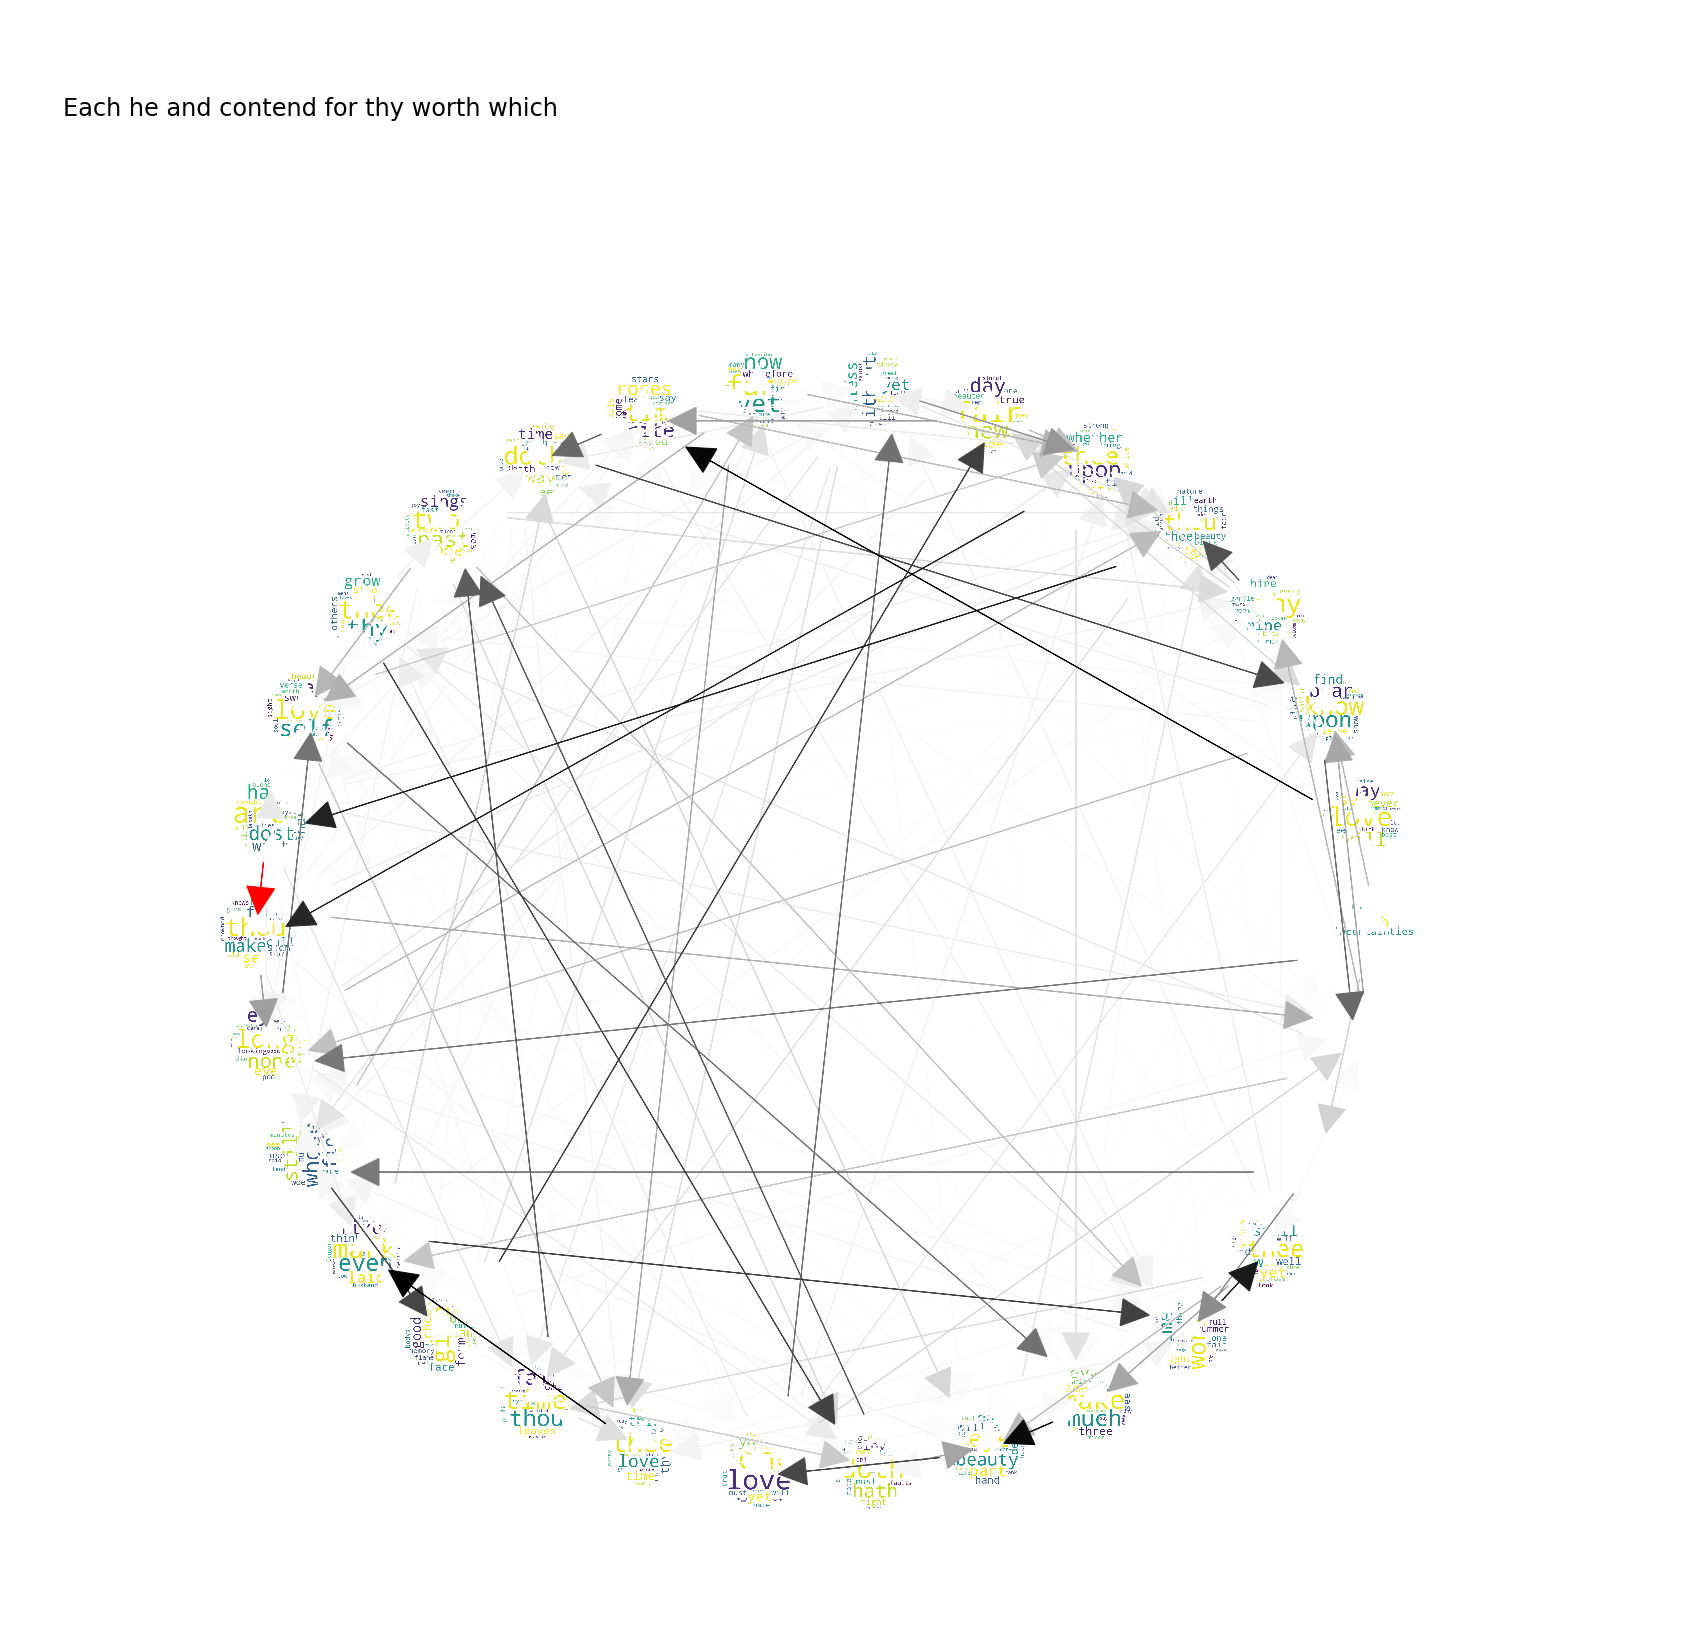

In [78]:
anim = animate_emission(hmm30states, obs_map, M=8)
HTML(anim.to_html5_video())